##Instalando y descargando librerías

In [62]:
!pip install Numpy Pandas Matplotlib yfinance beautifulsoup4 lxml

In [63]:
import numpy as np

In [64]:
import pandas as pd

In [65]:
import matplotlib.pyplot as plt

In [66]:
from matplotlib import colors

In [67]:
import yfinance as yf

In [68]:
import requests

In [69]:
from bs4 import BeautifulSoup

In [70]:
from IPython.display import clear_output

In [71]:
import time

##Declaración de variables globales

In [72]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision


## Función para extraer el histórico de precios de Bitcoin en los últimos 7 días en intervalos de 5 minutos


In [73]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  # df_bitcoin DataFrame
  #1.Utiliza la biblioteca yfinance de Python para extraer el histórico de precios del Bitcoin en dólares BTC-USD
  #2.extraer el histórico de los últimos 7 días en intervalos de 5 minutos, este histórico deberás guardarlo en el dataframe df_bitcoin.
  #1:
  df_bitcoin = (yf.download('BTC-USD', period='7d', interval='5m').round(2))

  return df_bitcoin

##Función para realizar "Web Scraping" y extraer el valor actual del "Bitcoin" BTC en dólares USD


In [74]:
def extraer_tendencias():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  #Web Scraping de la página https://coinmarketcap.com/ para extraer el precio actual del Bitcoin BTC en dólares USD y la variación de su precio en la última hora 1h %
  #El precio deberás convertirlo a float y guardarlo en la variable llamada precio_actual
  #Ahora, en la variable tendencia guarda el valor de 'baja'si la variación del precio es negativa, sino, guarda el valor de 'alta'.

  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'}
  url = 'https://coinmarketcap.com/'
  response = requests.get(url, headers=headers)
  soup = BeautifulSoup(response.content, "lxml")
  #Print(response.text)
  precio_actual = []
  tendencia = []
  precio_actual_str = soup.find('div',{'class':'sc-a0353bbc-0 gDrtaY'})
  precio_actual = float(precio_actual_str.text.replace('$', '').replace(',', ''))

  tendencia_str = soup.find('span',{'class':'sc-d55c02b-0 iwhBxy'})
  variacion_1h = float(tendencia_str.text.replace('%', '').strip())

  if(variacion_1h < 0):
    tendencia = 'baja'
  elif(variacion_1h > 0):
    tendencia = 'alta'

  return precio_actual, tendencia

##Función para realizar la limpieza de los datos, eliminar los Outliers



In [75]:
df_bitcoin = importar_base_bitcoin()
precio_actual, tendencia = extraer_tendencias()


[*********************100%%**********************]  1 of 1 completed


In [76]:
def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  df_bitcoin_limpio = df_bitcoin.copy()
  index = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = pd.DataFrame(data = df_bitcoin_limpio, index = index)
  seleccion = df_bitcoin_limpio['Volume'] <= 0
  df_bitcoin_limpio = df_bitcoin_limpio[~seleccion]
  #Aplicando BoxPlot:
  %matplotlib inline
  plt.rc('figure', figsize= (14,6))
  #Eliminando los OutLiers:
  valor = df_bitcoin_limpio['Close']
  Q1 = valor.quantile(0.25) #Primer cuartil
  Q3 = valor.quantile(0.75) #Tercer cuartil
  #Precios entre el primer y tercer cuartil del BoxPlot
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ

  medianaA = df_bitcoin_limpio[valor > IIQ]
  seleccion = (valor >= limite_inferior) & (valor <= limite_superior)
  media_bitcoin = df_bitcoin_limpio[seleccion]

  #Grafico BoxPlot
  # fill with colors
  #colors = ['lightgreen', 'lightblue', 'lightgreen', 'pink']
  #media_bitcoin.boxplot(['Close'])
  # rectangular box plot
  labels = 'x1'
  bplot = media_bitcoin.boxplot(['Close'],
                                  vert=True,  # vertical box alignment
                                  patch_artist=True, showmeans = True,
                                  meanline = True, boxprops = dict(facecolor = "lightblue"),
                                  medianprops = dict(color = "violet", linewidth = 1.5),
                                  capprops = dict(color = "blue", linewidth = 2),
                                  whiskerprops = dict(color = "blue", linewidth = 2))  # fill with color
  bplot.set_title('Histórico de operaciones en BTC ($)')
  plt.show()

  return media_bitcoin

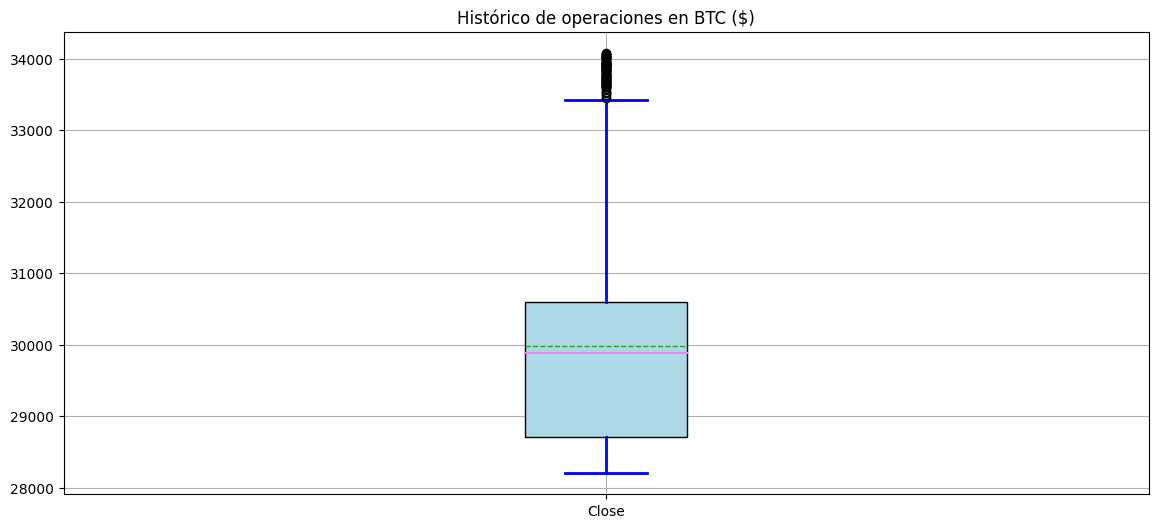

In [77]:
media_bitcoin = limpieza_datos()

## Función para la toma de decisiones en el histórico de los precios de cierre en el BTC ($)

In [78]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  precio_promedio =media_bitcoin.Close.mean().round(2)
  algoritmo_decision = []

  if((precio_actual >= precio_promedio) & (tendencia == 'baja')):
    algoritmo_decision = 'Vender'
    #print('Vender')
  elif((precio_actual < precio_promedio) & (tendencia == 'alta')):
    algoritmo_decision = 'Comprar'
    #print('Comprar')
  else:
    algoritmo_decision = 'Esperar'
    #print('Esperar')

  #print(algoritmo_decision)

  return algoritmo_decision

In [79]:
algoritmo_decision = tomar_decisiones()

##Función para la visualización de los datos provenientes del BTC ($)

In [84]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  Promedio = []
  df_bitcoin1 = df_bitcoin.copy()
  Promedio = (media_bitcoin.Close / len(media_bitcoin.Close))
  df_bitcoin1['Promedio'] = Promedio.round(2)
  df_bitcoin1['Mediana'] = media_bitcoin.Close.round(2)

  df_bitcoin1.fillna(method = 'ffill', limit=4,inplace=True)
  df_bitcoin1.fillna(method = 'bfill', limit=4,inplace=True)
  df_bitcoin1.fillna(method = 'ffill', limit=8,inplace=True)
  df_bitcoin1.fillna(method = 'bfill', limit=8,inplace=True)
  df_bitcoin1.fillna(method = 'ffill', limit=4,inplace=True)
  df_bitcoin1.fillna(method = 'bfill', limit=4,inplace=True)
  df_bitcoin1.fillna(method = 'ffill', limit=8,inplace=True)
  df_bitcoin1.fillna(method = 'bfill', limit=8,inplace=True)
  df_bitcoin1.fillna(method = 'ffill', limit=4,inplace=True)
  df_bitcoin1.fillna(method = 'bfill', limit=4,inplace=True)
  df_bitcoin1.fillna(method = 'ffill', limit=8,inplace=True)
  df_bitcoin1.fillna(method = 'bfill', limit=8,inplace=True)
  df_bitcoin1.fillna(method = 'ffill', limit=4,inplace=True)
  df_bitcoin1.fillna(method = 'bfill', limit=4,inplace=True)

  area = plt.figure(figsize= (16,8))

  g1 = area.add_subplot(2, 2, 1)
  area.suptitle('Graficos del historico de precios del BTC, 1_Original, 2_Tratado, 3_Tratado_con_relleno')
  x1 = df_bitcoin.index
  y1 = df_bitcoin.Close
  x21_1 = df_bitcoin.index[0]
  y21_1 = df_bitcoin.Close[0]
  x22_1 = df_bitcoin.index[-1]
  y22_1 = df_bitcoin.Close[-1]
  g1.plot(x1, y1,'g', [x21_1, x22_1], [y21_1, y22_1], 'violet')
  g1.set_title('1_ Historico de precios original BTC, 7d ')
  g1.set_xlabel('Fechas en el volumen en transacciones')
  g1.set_ylabel('Precio Actual del BTC ($)')

  g2 = area.add_subplot(2, 2, 2)
  x2_pos = media_bitcoin.index[media_bitcoin.Close > 0]
  x2_neg = media_bitcoin.index[media_bitcoin.Close < 0]
  y2_pos = media_bitcoin.Close[media_bitcoin.Close > 0]
  y2_neg = media_bitcoin.Close[media_bitcoin.Close < 0]
  x21_2 = media_bitcoin.index[0]
  y21_2 = media_bitcoin.Close[0]
  x22_2 = media_bitcoin.index[-1]
  y22_2 = media_bitcoin.Close[-1]
  g2.plot(x2_pos, y2_pos,'b',x2_neg, y2_neg,'r', [x21_2, x22_2], [y21_2, y22_2], 'violet')

  #g2.plot(x2, y2,'b', [x21_2, x22_2], [y21_2, y22_2], 'violet')
  if(algoritmo_decision == 'Comprar'):
    g2.annotate(algoritmo_decision, xy=(x2[400], y2[-20]), fontsize=14, color='blue')
  elif(algoritmo_decision == 'Vender'):
    g2.annotate(algoritmo_decision, xy=(x2[400], y2[-20]), fontsize=14, color='red')
  else:
    g2.annotate(algoritmo_decision, xy=(x2[400], y2[-20]), fontsize=14, color='orange')

  g2.set_title('2_ Historico de precios tratado Promedio BTC, 7d ')
  g2.set_xlabel('Fechas en el volumen en transacciones')
  g2.set_ylabel('Precio Actual del BTC ($)')

  g3 = area.add_subplot(2, 2, 3)
  x3 = df_bitcoin1.index
  y3 = df_bitcoin1.Mediana
  x21_3 = df_bitcoin1.index[0]
  y21_3 = df_bitcoin1.Mediana[0]
  x22_3 = df_bitcoin1.index[-1]
  y22_3 = df_bitcoin1.Mediana[-1]
  g3.plot(x3, y3,'brown', [x21_3, x22_3], [y21_3, y22_3], 'violet')
  g3.set_title('3_ Historico de precios tratado con relleno BTC, 7d ')
  g3.set_xlabel('Fechas en el volumen en transacciones')
  g3.set_ylabel('Precio Actual del BTC ($)')

  plt.show()

##Función Automatización de ejecuciones de las funciones globales

[*********************100%%**********************]  1 of 1 completed


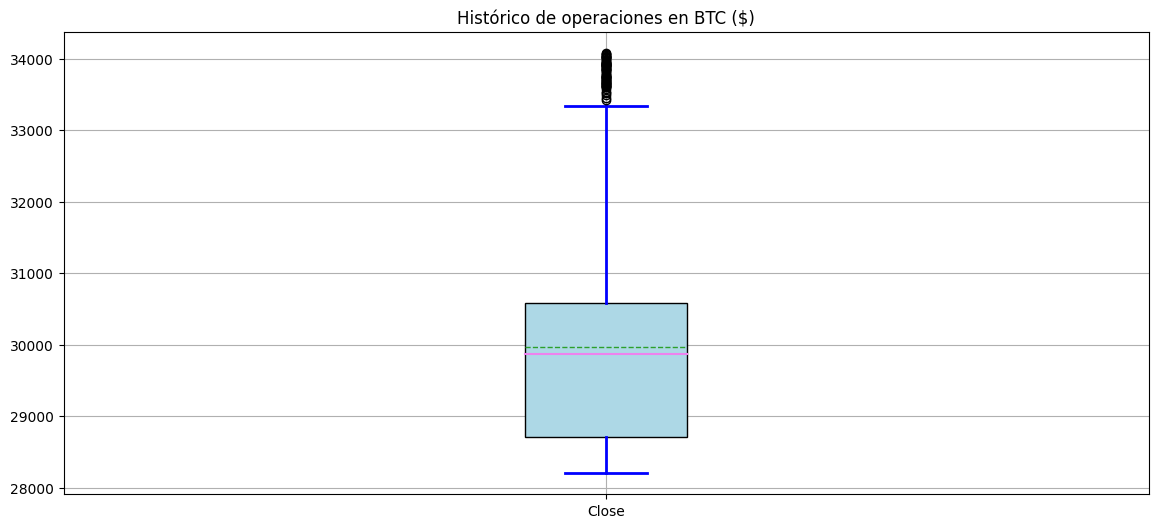

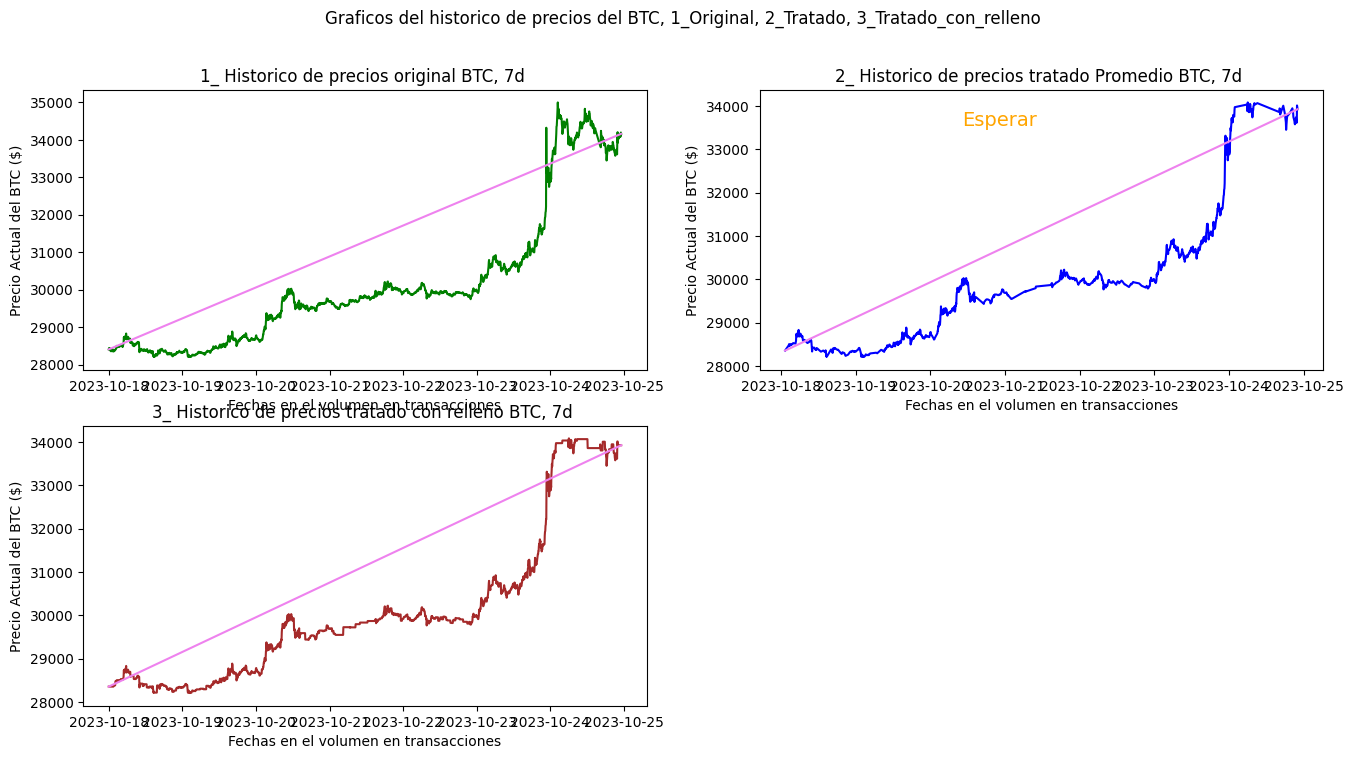

KeyboardInterrupt: ignored

In [85]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)

In [86]:
##Fin de la primera parte del Robot Trading